In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
!pip install konlpy
from konlpy.tag import Okt
import re
import pickle

from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers, losses, metrics
from keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
# WARNING 무시
warnings.filterwarnings('ignore')

#데이터 불러오기

In [ ]:
corpus = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ssac/nlp/data/음식점_train.csv')
corpus

,IDX,발화자,발화문,카테고리,QA번호,QA여부,감성,인텐트,가격,수량,크기,장소,조직,사람,시간,날짜,상품명,상담번호,상담내순번
0,1,c,"참치타다끼샐러드는 취소했었는데, 맞죠?",음식점,32365,q,m,주문_취소_확인,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,참치타다끼샐러드,32365,1
1,2,s,"네, 참치타다끼샐러드는 취소된 상태입니다.",음식점,32365,a,m,주문_취소_확인,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,참치타다끼샐러드,32365,2
2,3,c,주문한 메뉴 취소할 때 주문서만 있으면 된다는 말씀이세요?,음식점,15016,q,m,주문_취소_확인,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15016,1
3,4,s,"네, 주문서만 있으면 취소 가능합니다.",음식점,15016,a,m,주문_취소_확인,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15016,2
4,5,c,고객서비스가 엉망이군요. 그냥 갑니다.,음식점,62984,q,n,주문_취소_확인,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62984,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290382,290383,s,성북동까지 지금 시간에는 40분 이상 걸립니다.,음식점,50614,a,m,배송_날짜_요청,NaN,NaN,NaN,성북동,NaN,NaN,NaN,NaN,NaN,50614,2
290383,290384,c,짜장면 지금 주문하면 바로 배달 올 수 있죠?,음식점,18579,q,m,배송_날짜_요청,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,짜장면,18579,1
290384,290385,s,"네, 지금 주문하시면 바로 배달 갑니다.",음식점,18579,a,m,배송_날짜_요청,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18579,2
290385,290386,c,롯데유치원에 피자 20판 보내야하는데 5시까지 될까요?,음식점,59570,q,m,배송_날짜_요청,NaN,NaN,NaN,롯데유치원,NaN,NaN,5시,NaN,피자,59570,1


In [ ]:
# 질문과 대답형식의 데이터로 변경
Q = []
A = []
flag = 0
for i in tqdm(range(len(corpus))):
  if flag > i :
    pass
  else :
    if corpus.iloc[i]['QA여부'] == 'q':
      list_q = []
      list_q.append(corpus.iloc[i]['발화문'])
      for j in range(i+1, len(corpus)):
        if corpus.iloc[j]['QA여부'] == 'a':
          flag = j
        if flag == j:
          break
        else : 
          list_q.append(corpus.iloc[j]['발화문'])
      Q.append(' '.join(list_q))
    else :
      list_a = []
      list_a.append(corpus.iloc[i]['발화문'])
      for j in range(i+1, i+50):
        try : 
          if corpus.iloc[j]['QA여부'] == 'q':
            flag = j

          if flag == j:
            break
          else : 
            list_a.append(corpus.iloc[j]['발화문'])
        except :
          pass
      A.append(' '.join(list_a))

100%|██████████| 290387/290387 [01:31<00:00, 3190.49it/s]


In [ ]:
corpus = pd.DataFrame({'Q':Q, 'A':A})
corpus

,Q,A
0,"참치타다끼샐러드는 취소했었는데, 맞죠?","네, 참치타다끼샐러드는 취소된 상태입니다."
1,주문한 메뉴 취소할 때 주문서만 있으면 된다는 말씀이세요?,"네, 주문서만 있으면 취소 가능합니다."
2,고객서비스가 엉망이군요. 그냥 갑니다.,원하시는 서비스를 제공하지못해 죄송합니다.
3,방금 전에 홍합탕 주문한 거 지금 취소 가능한 거 맞죠?,"네, 주문하신 홍합탕은 아직 조리 전이라 취소 가능합니다."
4,"매운무뼈닭발 롯데주유소로 주문한 거 아직 안받았는데, 취소해도 되는 거죠?","아니요, 이미 접수 후 조리 시작하여 취소는 어렵습니다."
...,...,...
119372,짜장면 12:30까지 배달되야 먹는데 그 시간까지 오실 수 있나요?,"네, 말씀하신 시간까지 배달해 드릴게요."
119373,후라이드 5마리 시킨 곳인데 배달 출발한 거 확실해요?,"네, 배달 출발한 건지 알아 보고 연락 드리겠습니다."
119374,성북동까지 치킨 배달시키면 얼마나 걸리는지 알려주세요.,성북동까지 지금 시간에는 40분 이상 걸립니다.
119375,짜장면 지금 주문하면 바로 배달 올 수 있죠?,"네, 지금 주문하시면 바로 배달 갑니다."


In [ ]:
#대답이 '네'인 데이터는 제거
corpus = corpus[corpus['A'] != '네'][corpus['A'] != '네.']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


# 데이터 전처리

In [ ]:
#데이터를 리스트로
df = corpus['Q']
get_all_texts = df.values.tolist()
df = corpus['A']
get_all_pairs = df.values.tolist()

In [ ]:
texts = []
pairs = []

for text, pair in zip(get_all_texts, get_all_pairs):
    texts.append(text)
    pairs.append(pair)
list(zip(texts, pairs))[:5]

[('참치타다끼샐러드는 취소했었는데, 맞죠?', '네, 참치타다끼샐러드는 취소된 상태입니다.'),
 ('주문한 메뉴 취소할 때 주문서만 있으면 된다는 말씀이세요?', '네, 주문서만 있으면 취소 가능합니다.'),
 ('고객서비스가 엉망이군요. 그냥 갑니다.', '원하시는 서비스를 제공하지못해 죄송합니다.'),
 ('방금 전에 홍합탕 주문한 거 지금 취소 가능한 거 맞죠?', '네, 주문하신 홍합탕은 아직 조리 전이라 취소 가능합니다.'),
 ('매운무뼈닭발 롯데주유소로 주문한 거 아직 안받았는데, 취소해도 되는 거죠?',
  '아니요, 이미 접수 후 조리 시작하여 취소는 어렵습니다.')]

In [ ]:
def clean_sentence(sentence):
    sentence = re.sub(r'[^0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]',r'', sentence)
    return sentence

In [ ]:
okt = Okt()
def process_morph(sentence):
    return ' '.join(okt.morphs(sentence))

In [ ]:
def clean_and_morph(sentence, is_question=True):
    # 한글 문장 전처리
    sentence = clean_sentence(sentence)
    # 형태소 변환
    sentence = process_morph(sentence)
    # Question 인 경우, Answer인 경우를 분기하여 처리
    if is_question:
        return sentence
    else:
        # <SOS> 토큰은 decoder input에 <EOS> 토큰은 decoder output에 추가
        return ('<SOS> ' + sentence, sentence + ' <EOS>')

In [ ]:
def preprocess(texts, pairs):
    questions = []
    answer_in = []
    answer_out = []

    # 질의에 대한 전처리
    for text in texts:
        question = clean_and_morph(text, is_question=True) # 질문
        questions.append(question)

    # 답변에 대한 전처리
    for pair in pairs:
        in_, out_ = clean_and_morph(pair, is_question=False) # pair 답변
        answer_in.append(in_)
        answer_out.append(out_)
    
    return questions, answer_in, answer_out
  

In [ ]:
#데이터 사이즈 조정
texts = texts[:5000] # 램
pairs = pairs[:5000]

In [ ]:
#데이터 전처리 적용
questions, answer_in, answer_out = preprocess(texts, pairs)

In [ ]:
#단어사전 생성
all_sentences = questions + answer_in + answer_out
a = (' '.join(questions) + ' '.join(answer_in) + ' '.join(answer_out)).split()
len(set(a))

5164

In [ ]:
#tokenizer 정의
tokenizer = Tokenizer(filters='', lower=False, oov_token='<OOV>')

In [ ]:
tokenizer.fit_on_texts(all_sentences)
for word, idx in tokenizer.word_index.items():
    print(f'{word}\t\t => \t{idx}')
    if idx > 10:
        break

<OOV>		 => 	1
<SOS>		 => 	2
<EOS>		 => 	3
네		 => 	4
배달		 => 	5
이		 => 	6
비		 => 	7
가		 => 	8
요		 => 	9
에		 => 	10
는		 => 	11


In [36]:
EMBEDDING_DIM = 100      # 임베딩 벡터 차원
LSTM_HIDDEN_DIM = 128    # LSTM 히든레이어 차원
MAX_LENGTH = 30
TRUNCATING = 'post'      #문장이 30을 넘어갈 경우 뒤에서 자르기
PADDING = 'post'         #뒤에서부터 0으로 패딩
VOCAB_SIZE = len(tokenizer.word_index) + 1  # 나중에 <PAD> 위해 +1


In [ ]:
#시퀀스 변환
question_sequence = tokenizer.texts_to_sequences(questions)
answer_in_sequence = tokenizer.texts_to_sequences(answer_in)
answer_out_sequence = tokenizer.texts_to_sequences(answer_out)

In [ ]:
#패딩
question_padded = pad_sequences(question_sequence, maxlen=MAX_LENGTH, truncating=TRUNCATING, padding=PADDING)
answer_in_padded = pad_sequences(answer_in_sequence, maxlen=MAX_LENGTH, truncating=TRUNCATING, padding=PADDING)
answer_out_padded = pad_sequences(answer_out_sequence, maxlen=MAX_LENGTH, truncating=TRUNCATING, padding=PADDING)
  
question_padded.shape

(5000, 30)

In [ ]:
def convert_to_one_hot(padded):
    # 원핫인코딩 초기화
    one_hot_vector = np.zeros((len(answer_out_padded), MAX_LENGTH, VOCAB_SIZE))
    # 학습시 입력은 인덱스이지만, 출력은 원핫인코딩 형식
    for i, sequence in enumerate(answer_out_padded):
        for j, index in enumerate(sequence):
            one_hot_vector[i, j, index] = 1

    return one_hot_vector

In [ ]:
answer_in_one_hot = convert_to_one_hot(answer_in_padded)
answer_out_one_hot = convert_to_one_hot(answer_out_padded)
answer_in_one_hot[0].shape, answer_in_one_hot[0].shape

((30, 5164), (30, 5164))

In [ ]:
def convert_index_to_text(indexs, end_token): 
    
    sentence = ''
  
    for index in indexs:
        if index == end_token:
            break;
        # 사전에 존재하는 단어의 경우 단어 추가
        if index > 0 and tokenizer.index_word[index] is not None:
            sentence += tokenizer.index_word[index]
        else:
        # 사전에 없는 인덱스면 빈 문자열 추가
            sentence += ''
       
        sentence += ' '
    return sentence

In [ ]:
def make_prediction(model, question_inputs):
    results = model(inputs=question_inputs, training=False)
    # 변환된 인덱스를 문장으로 변환
    results = np.asarray(results).reshape(-1)
    return results

# 모델링

In [ ]:
#--------------------------------------------
# 훈련 모델 인코더 정의
#--------------------------------------------

# 입력 문장의 인덱스 시퀀스를 입력으로 받음
encoder_inputs = layers.Input(shape=(None,))

# 임베딩 레이어
encoder_outputs = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(encoder_inputs)

# return_state가 True면 상태값 리턴
# LSTM은 state_h(hidden state)와 state_c(cell state) 2개의 상태 존재
encoder_outputs, state_h, state_c = layers.LSTM(LSTM_HIDDEN_DIM,
                                                dropout=0.1,
                                                recurrent_dropout=0.5, 
                                                return_state=True)(encoder_outputs) # 히든 스테이트와 셀 스테이를 반환해라 True 안하면 encoder_output(state_h)만 반환

# 히든 상태와 셀 상태를 하나로 묶음
encoder_states = [state_h, state_c]



#--------------------------------------------
# 훈련 모델 디코더 정의
#--------------------------------------------

# 목표 문장의 인덱스 시퀀스를 입력으로 받음
decoder_inputs = layers.Input(shape=(None,))

# 임베딩 레이어
decoder_embedding = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
decoder_outputs = decoder_embedding(decoder_inputs)


# 인코더와 달리 return_sequences를 True로 설정하여 모든 타임 스텝 출력값 리턴
# 모든 타임 스텝의 출력값들을 다음 레이어의 Dense()로 처리하기 위함
decoder_lstm = layers.LSTM(LSTM_HIDDEN_DIM,
                           dropout=0.1,
                           recurrent_dropout=0.5,
                           return_state=True,
                           return_sequences=True) # False하면 아웃풋스테이트(state_h, 최종단어)만 나오는데 True는 출력값(단어)이 다 나온다. 

# initial_state를 인코더의 상태로 초기화
decoder_outputs, _, _ = decoder_lstm(decoder_outputs,
                                     initial_state=encoder_states)

# 단어의 개수만큼 노드의 개수를 설정하여 원핫 형식으로 각 단어 인덱스를 출력
decoder_dense = layers.Dense(VOCAB_SIZE, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)



#--------------------------------------------
# 훈련 모델 정의
#--------------------------------------------

# 입력과 출력으로 함수형 API 모델 생성
model = models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 학습 방법 설정
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])    

In [ ]:
#--------------------------------------------
#  예측 모델 인코더 정의
#--------------------------------------------

# 훈련 모델의 인코더 상태를 사용하여 예측 모델 인코더 설정
encoder_model = models.Model(encoder_inputs, encoder_states)



#--------------------------------------------
# 예측 모델 디코더 정의
#--------------------------------------------

# 예측시에는 훈련시와 달리 타임 스텝을 한 단계씩 수행
# 매번 이전 디코더 상태를 입력으로 받아서 새로 설정
decoder_state_input_h = layers.Input(shape=(LSTM_HIDDEN_DIM,))
decoder_state_input_c = layers.Input(shape=(LSTM_HIDDEN_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]    

# 임베딩 레이어
decoder_outputs = decoder_embedding(decoder_inputs)

# LSTM 레이어
decoder_outputs, state_h, state_c = decoder_lstm(decoder_outputs,
                                                 initial_state=decoder_states_inputs)

# 히든 상태와 셀 상태를 하나로 묶음
decoder_states = [state_h, state_c]

# Dense 레이어를 통해 원핫 형식으로 각 단어 인덱스를 출력
decoder_outputs = decoder_dense(decoder_outputs)

# 예측 모델 디코더 설정
decoder_model = models.Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

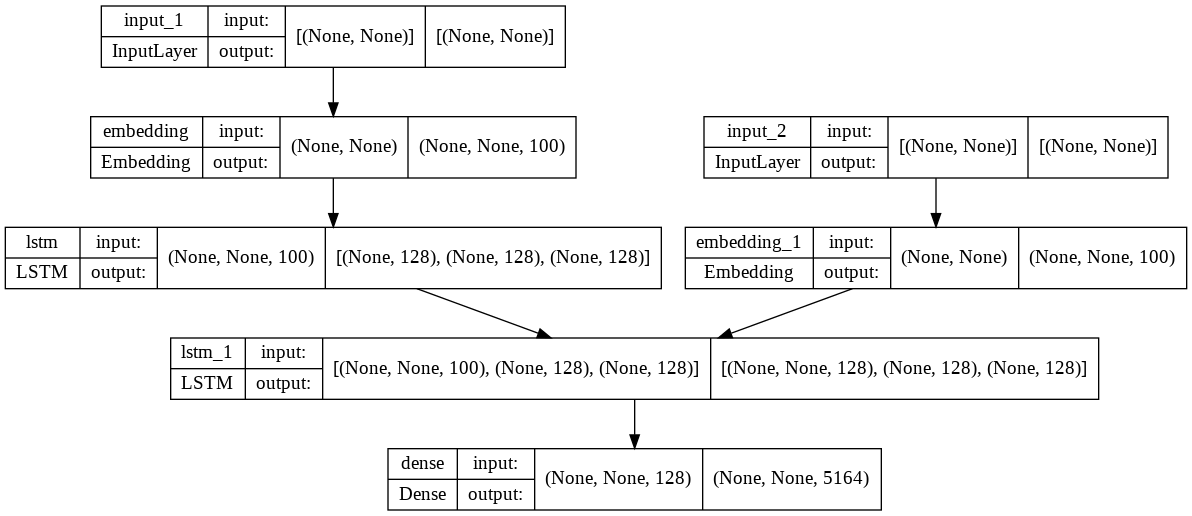

In [49]:
tf.keras.utils.plot_model(
    model, to_file='small_transformer.png', show_shapes=True) # 층 모양 시각화

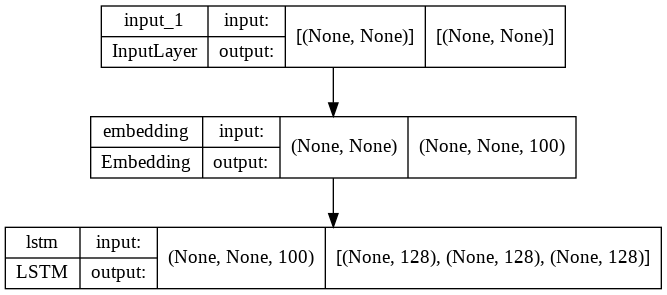

In [47]:
tf.keras.utils.plot_model(
    encoder_model, to_file='small_transformer.png', show_shapes=True)

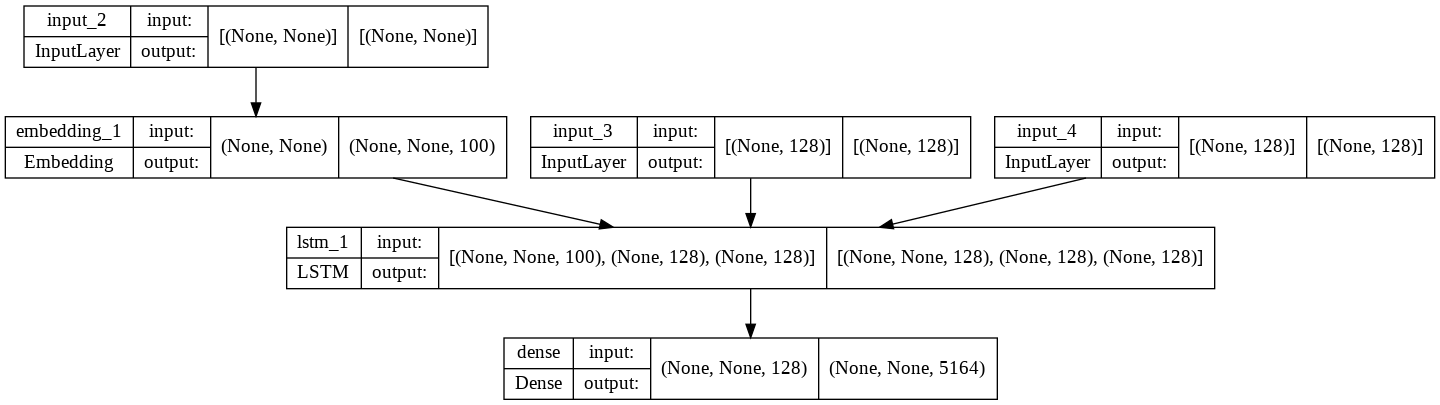

In [48]:
tf.keras.utils.plot_model(
    decoder_model, to_file='small_transformer.png', show_shapes=True)

In [ ]:
# 에폭 반복
for epoch in range(15):
    print(f'processing epoch: {epoch * 10 + 1}...')

    # 훈련 시작
    history = model.fit([question_padded, answer_in_padded],
                        answer_out_one_hot,
                        epochs=10,
                        batch_size=64)
    # 랜덤한 샘플 번호 추출
    samples = np.random.randint(5000, size=3)

    # 예측 성능 테스트
    for idx in samples:
        # 문장 예측
        input_encoder = question_padded[idx].reshape(1, question_padded[idx].shape[0])
        input_decoder = answer_in_padded[idx].reshape(1, answer_in_padded[idx].shape[0])
        results = model.predict([input_encoder, input_decoder])
        indexs = np.argmax(results[0], 1) 
    
        # 변환된 인덱스를 문장으로 변환
        results = convert_index_to_text(indexs, tokenizer.word_index['<EOS>'])
        
        print(f'Q: {questions[idx]}')
        print(f'A: {results}\n')
        print()

processing epoch: 1...
Epoch 1/10
79/79 [==============================] - 25s 203ms/step - loss: 2.4160 - acc: 0.7656
Epoch 2/10
79/79 [==============================] - 17s 211ms/step - loss: 1.3299 - acc: 0.8041
Epoch 3/10
79/79 [==============================] - 16s 203ms/step - loss: 1.2317 - acc: 0.8183
Epoch 4/10
79/79 [==============================] - 16s 203ms/step - loss: 1.1932 - acc: 0.8217
Epoch 5/10
79/79 [==============================] - 16s 203ms/step - loss: 1.1679 - acc: 0.8230
Epoch 6/10
79/79 [==============================] - 16s 202ms/step - loss: 1.1349 - acc: 0.8267
Epoch 7/10
79/79 [==============================] - 16s 202ms/step - loss: 1.1019 - acc: 0.8302
Epoch 8/10
79/79 [==============================] - 16s 203ms/step - loss: 1.0728 - acc: 0.8325
Epoch 9/10
79/79 [==============================] - 16s 202ms/step - loss: 1.0468 - acc: 0.8347
Epoch 10/10
79/79 [==============================] - 16s 204ms/step - loss: 1.0242 - acc: 0.8366
Q: 나물 반찬 3 종 세트 

In [ ]:
# 모델 저장
encoder_model.save('/content/drive/MyDrive/Colab Notebooks/ssac/nlp/model/encoder_model.h5')
decoder_model.save('/content/drive/MyDrive/Colab Notebooks/ssac/nlp/model/decoder_model.h5')

with open('/content/drive/MyDrive/Colab Notebooks/ssac/nlp/tokenizer/seq2seq_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)